'서부산 관광지의 마케팅 전략' 프로젝트 정리의 세 번째 시간입니다. 이전 게시글에서는 영어로 작성된 리뷰의 빈도 분석과 토픽 모델링을 진행하였습니다. 이번에는 한국어 리뷰의 빈도 분석과 토픽 모델링 과정에 대해 정리해보도록 하겠습니다.

한국어 데이터는 비교적 외국인의 방문이 적은 서부산 관광지의 5곳에서 수집하였습니다. 5개의 데이터에 동일한 방법을 적용하였기 때문에, 이번에도 다대포 해수욕장의 리뷰를 텍스트 분석하는 과정만 예시로 사용하였습니다.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from ckonlpy.tag import Twitter
import warnings
import gensim
from gensim import corpora, models
from pprint import pprint

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [4]:
df = pd.read_csv('Dadaepo Final.csv')
df.head()

,DATE,RATING,REVIEW
0,2020-06-08,5,몰운대쪽도 좋아요 분수대있는곳에서 편의점.식당있는곳으로 작은 골목지나면 이런곳이 나...
1,2020-02-21,4,넓은 모래가 매력적 다대포 해수욕장의 모래사장은 다른 해수욕장보다 더 넓은 것 같다...
2,2019-11-17,5,해넘이를 보아야 할 부산의 일몰 명소 부산의 제일 서쪽 낙동강 하구에 있는 해수욕장...
3,2019-11-12,4,"조용한 바닷가, 좋은 곳 해운대, 광안리, 송정과는 완전히 다른 바닷가와 해변......"
4,2019-10-16,5,바다미술제 2년만에 한번씩 비엔날레로 바다미술제가 10월 28일까지 해요.지금도 다...


Topic Modeling을 진행할 때에는 리뷰 단위로 문서를 나누고 해당 리뷰의 의미를 찾아내기 위해 리스트로 분리해주어야합니다. 따라서 리스트의 형태로 저장해주었습니다.

In [5]:
r_list = list(df['REVIEW'])
r_list[:2]

['몰운대쪽도 좋아요 분수대있는곳에서 편의점.식당있는곳으로 작은 골목지나면 이런곳이 나와요.몇년째 방문해오지만처음 와봤어요ㅋㅋ.새로 정비해서 해안가선도 이쁘고 깔끔해요.식당까페등 더 정비가 되면 더 좋을거같습니다',
 '넓은 모래가 매력적 다대포 해수욕장의 모래사장은 다른 해수욕장보다 더 넓은 것 같다.지하철로 갈 수 있어서 접근성은 좋지만 다른 곳에 비해서는 외진 곳에 위치해서 현지인들이나 주변도시 사람들이 찾는 듯하다.']

## 1. 텍스트 전처리

### 1.1. 리뷰 정제

In [6]:
def text_cleaning(review_list):
    # 한글만 남기기
    cleaned = [re.sub('[^가-힣]+', ' ', text) for text in review_list]
    
    return cleaned

먼저, 리뷰 텍스트에서 특수문자와 숫자 등을 제거하고 한글만 남겼습니다.

In [7]:
clean_list = text_cleaning(r_list)
clean_list[:2]

['몰운대쪽도 좋아요 분수대있는곳에서 편의점 식당있는곳으로 작은 골목지나면 이런곳이 나와요 몇년째 방문해오지만처음 와봤어요 새로 정비해서 해안가선도 이쁘고 깔끔해요 식당까페등 더 정비가 되면 더 좋을거같습니다',
 '넓은 모래가 매력적 다대포 해수욕장의 모래사장은 다른 해수욕장보다 더 넓은 것 같다 지하철로 갈 수 있어서 접근성은 좋지만 다른 곳에 비해서는 외진 곳에 위치해서 현지인들이나 주변도시 사람들이 찾는 듯하다 ']

text_cleaning 함수를 적용하여 clean_list에 정제한 결과를 저장합니다.

### 1.2. 어근 추출(Stemming)과 토큰화

리뷰 데이터는 인터넷에서 작성된 글의 특성상 신조어나 줄임말이 많습니다. 이러한 단어가 나누어지는 것을 방지하기 위해 형태소 분석기로 twitter를 사용하였습니다. twitter는 add_dictionary를 이용하여 사전에 추가할 수 있기 때문입니다.

In [8]:
# 사용 예시 - 사전 추가 전
twitter = Twitter()
twitter.morphs('다대포 해수욕장의 모래사장은 더 넓은 것 같다')

['다대', '포', '해수욕장', '의', '모래사장', '은', '더', '넓은', '것', '같다']

In [9]:
# 사전에 추가
twitter.add_dictionary('다대포', 'Noun')
twitter.morphs('다대포 해수욕장의 모래사장은 더 넓은 것 같다')

['다대포', '해수욕장', '의', '모래사장', '은', '더', '넓은', '것', '같다']

twitter 기본 형태소 분석기에서는 다대포를 다대 와 포로 분리하지만, 사전에 다대포를 추가한 후에는 다대포를 정상적으로 분리되는 것을 확인할 수 있습니다.

In [10]:
# 다대포 해수욕장 리뷰 분석에서 사용할 사전
twitter = Twitter()
add_list = ['다대포', '분수쇼', '백사장', '낙조', '몰운대', '분수대',
           '하구', '광안리', '미술제', '포토존', '하구', '서부산']
for word in add_list:
    twitter.add_dictionary(word, 'Noun')

add_list는 토큰화 과정을 반복하며 어근 추출이 제대로 이루어지는지를 확인하며, dictionary에 추가할 단어를 정리하였습니다.

In [11]:
# 토큰화 함수 정의
def morphs_tokenizer(c):
    global twitter

    morphs = []
    for i in range(len(c)):
        # stem : 어근 추출 // norm : 정규화
        morphs.append(twitter.morphs(c[i], stem=True, norm=True))

    return morphs

In [12]:
morphs = morphs_tokenizer(clean_list)
print(morphs[0])

['몰운대', '쪽', '도', '좋다', '분수대', '있다', '곳', '에서', '편의점', '식당', '있다', '곳', '으로', '작다', '골목', '지나', '면', '이런', '곳', '이', '나오다', '몇', '년', '째', '방', '문해', '오지', '만', '처음', '오다', '보다', '어요', '새롭다', '정비', '해서', '해안가', '선도', '이쁘다', '깔끔하다', '식당', '까페', '등', '더', '정비', '가', '되다', '더', '좋다', '같다']


다음과 같이 토큰화된 모습입니다.

### 1.3. stopword 제거

마지막으로 분석에 도움이 되지 않는 stopword를 제거하였으며, 한 글자의 단어들은 의미가 없는 경우가 많기 때문에 두 글자 이상의 단어만 남겨두었습니다.

In [13]:
def define_stopwords(path):
    
    # 한국어 불용어 txt 파일 불러오기 
    SW = list(set())
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.append(word.rstrip())

    return SW

In [14]:
def delete_stopwords(text):
    global SW
    
    morphs_sw = []
    for i in range(len(text)):
        t = []
        for j in range(len(text[i])):
            if (text[i][j] not in SW) and (len(text[i][j]) > 1):
                t.append(text[i][j])
        morphs_sw.append(t)
    
    return morphs_sw

In [43]:
SW = define_stopwords('stopwords-ko.txt')
# stopword 추가
SW += ['너무', '들다', '보다', '들이다', '다운', '않다', '많이']

In [44]:
tokenized = delete_stopwords(morphs)
print(tokenized[0])

['몰운대', '좋다', '분수대', '편의점', '식당', '작다', '골목', '나오다', '문해', '처음', '오다', '새롭다', '정비', '해안가', '선도', '이쁘다', '깔끔하다', '식당', '까페', '정비', '좋다']


## 2. LDA Topic Modeling

전처리가 모두 끝났습니다. 전처리된 데이터를 가지고 LDA 토픽 모델링을 실시하였습니다.

In [45]:
dictionary = corpora.Dictionary(tokenized)
print(dictionary)

Dictionary<1664 unique tokens: ['골목', '까페', '깔끔하다', '나오다', '몰운대']...>


<필터링 기준>
- 10개 문서 이하에서 등장 (너무 개수가 적은 경우)
- 전체 corpus 사이즈의 0.5 이상에서 등장 (너무 개수가 많은 경우)

필터링 조건에 따라 빈도수 기준 상위 100,000개의 토큰만 추출하였습니다.

In [69]:
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in tokenized]

다음으로 단순 빈도 기반의 corpus를 tf-idf로 변환합니다.

In [70]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3718207110444853),
 (1, 0.2945078956976876),
 (2, 0.3718207110444853),
 (3, 0.24680905884195836),
 (4, 0.2945078956976876),
 (5, 0.6993670030060993)]


이제 7개의 토픽으로 LDA 토픽 모델링을 실시하겠습니다. gensim 패키지를 사용하여 LDA 모델링을 실시하였습니다.

In [71]:
NUM_TOPICS = 7
ldamodel = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, passes=15, random_state=902, 
                                           alpha="auto", eta="auto")

In [72]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07
0,바다,사람,일몰,자다,해수욕장,놀다,넓다
1,한적,오다,멋지다,주차,다대포,바닷가,경치
2,이쁘다,서핑,아름,가다,부산,가족,모래사장
3,없다,장소,최고,공원,시설,산책,그리
4,조개,사진,백사장,체험,낙동강,깨끗,지는
5,맛조개,모래,방문,바람,가기,좋아지다,풍경
6,잡다,많다,넓다,주차장,아름,얕다,깊다
7,분수,해운대,걷기,석양,몰운대,파도,여름
8,싶다,분수대,해수욕장,그늘,다대포해수욕장,수심,느낌
9,멀다,공간,재미,산책로,낙조,차다,해수욕장


다음과 같이 토픽 모델링이 완료되었습니다. 결과에 대한 해석은 다음 게시글에서 한 번에 진행하도록 하겠습니다.

## 3. TF-IDF 빈도분석

토큰화된 텍스트 데이터를 띄워쓰기로 연결하여 역토큰화한 후 빈도 분석을 진행하였습니다.

In [73]:
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized[i])
    detokenized_doc.append(t)

df['REVIEW'] = detokenized_doc

In [74]:
vectorizer = TfidfVectorizer(max_features= 1000) # 상위 1,000개의 단어를 보존 
tdm = vectorizer.fit_transform(df['REVIEW'])
tdm.shape # TF-IDF 행렬의 크기 확인

(820, 1000)

In [75]:
tfidf_weights = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
tfidf_weights[0:10]

[('몰운대', 5.598384902324651),
 ('좋다', 106.74388847216815),
 ('분수대', 4.685325526744318),
 ('식당', 1.5447491039808088),
 ('작다', 1.5941022493391785),
 ('나오다', 1.8564859807388148),
 ('처음', 3.746296729482263),
 ('오다', 11.279738354987536),
 ('새롭다', 1.7571735403145452),
 ('정비', 3.9036283886351004)]

### 3.1. TF-IDF 빈도분석 결과

In [ ]:
word_count = pd.DataFrame({'Word': vectorizer.get_feature_names(), 
                           'Frequency': tdm.sum(axis=0).flat})

In [77]:
word_count.sort_values('Frequency', ascending=False).head(10)

,Word,Frequency
741,좋다,106.743888
213,놀다,32.703265
932,해수욕장,23.477106
617,일몰,22.768573
482,아름,19.921506
227,다대포,19.733799
401,산책,19.560301
100,공원,18.556797
208,넓다,17.192626
800,최고,16.961309


빈도분석 결과를 word_count에 저장하였습니다. 프로젝트에서 사용하지는 않았지만, 위의 결과를 바탕으로 빈도에 대한 그래프를 시각화하는 등의 활용이 가능합니다.

### 3.2. 워드 클라우드

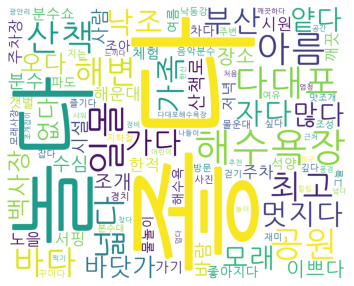

In [57]:
wc = WordCloud(
    width=1500,
    height=1200,
    font_path='/usr/share/fonts/NanumGothicCoding.ttf',
    background_color='white',
    max_words=100
).fit_words(
    dict(tfidf_weights)
)  # 상위 100개 단어만 보기 

plt.figure(figsize=(20,5))
plt.imshow(wc)
plt.axis('off');

마지막으로 빈도 분석 결과를 워드 클라우드로 나타냈습니다. 이 역시 다음 게시글에서 한 번에 해석해보도록 하겠습니다.

영어 텍스트 분석과 과정이 동일하기 때문에 빠르게 한국어 텍스트 분석을 정리해보았습니다. SNA 분석은 제가 아닌 다른 팀원이 진행하여 코드 정리는 생략하기로 하였습니다.다음 게시글에서는 동부산의 영어 리뷰 분석 결과와 서부산의 한글 리뷰 분석 결과를 비교하고, 마케팅 전략을 제안하며 프로젝트 정리를 마무리해보도록 하겠습니다.

오늘도 제 글 읽어주셔서 감사합니다.